## Objective

Use L2 Lasso regularization, see:
- if $R^2$ improves from 0.56
- whether we avoid crazy `y_pred`s (presumably from overfitting)
- which coefficients drop to 0

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 20, 5
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style("whitegrid")
sns.set_context("poster")

from helper_functions import dummify_cols_and_baselines, make_alphas, remove_outliers_by_type

In [2]:
df_orig = pd.read_pickle('../data/data_from_remove_from_dataset.pkl')
df_orig.shape

(516406, 40)

## Removing outliers

A standard procedure is to remove values further than 3 standard deviations from the mean. Since I have so many low values and some very high values, I anecdotally think that the low values are very likely to be true, and the high values not so much.

So, I will remove values further than 3 SDs from the median, by type.

Ideally, I would take into account the time dimension. I would like to do so given more time.

In [3]:
df_outliers_removed = remove_outliers_by_type(df_orig, y_col='COMPLETION_HOURS_LOG_10')
df_outliers_removed.shape

helper_functions.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  group[pd.np.abs(group - group.median()) > stds * group.std()] = pd.np.nan
/home/ec2-user/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2454: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


(508653, 40)

I'm removing ~1.5% of my rows.

## Removing columns

In [4]:
cols_orig_dataset = ['COMPLETION_HOURS_LOG_10', 'TYPE', 'SubmittedPhoto', 'Property_Type', 'Source', 'neighborhood_from_zip']
cols_census = ['race_white',
     'race_black',
     'race_asian',
     'race_hispanic',
     'race_other',
     'poverty_pop_below_poverty_level',
     'earned_income_per_capita',
     'poverty_pop_w_public_assistance',
     'poverty_pop_w_food_stamps',
     'poverty_pop_w_ssi',
     'school',
     'school_std_dev',
     'housing',
     'housing_std_dev',
     'bedroom',
     'bedroom_std_dev',
     'value',
     'value_std_dev',
     'rent',
     'rent_std_dev',
     'income',
     'income_std_dev']
cols_engineered = ['queue_wk', 'queue_wk_open', 'is_description']

In [5]:
df = df_outliers_removed[cols_orig_dataset + cols_census + cols_engineered]

## Dummify

In [6]:
cols_to_dummify = df.dtypes[df.dtypes == object].index
cols_to_dummify

Index([u'TYPE', u'Property_Type', u'Source', u'neighborhood_from_zip',
       u'school', u'housing'],
      dtype='object')

In [7]:
df_dummified, baseline_cols = dummify_cols_and_baselines(df, cols_to_dummify)

Zoning is baseline 0 6
other is baseline 1 6
Twitter is baseline 2 6
West Roxbury is baseline 3 6
8_6th_grade is baseline 4 6
rent is baseline 5 6


In [8]:
df_dummified.shape

(508653, 253)

## Running model

In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df_dummified.drop('COMPLETION_HOURS_LOG_10', axis=1), 
    df_dummified.COMPLETION_HOURS_LOG_10, 
    test_size=0.2, 
    random_state=300
)

In [31]:
pipe = make_pipeline(StandardScaler(), RandomForestRegressor(verbose=100))

In [12]:
cv = ShuffleSplit(X_train.shape[0], n_iter=1, test_size=0.2, random_state=300)

In [52]:
# I wanted to use oob_score but need for loop
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
# decided that with mulitple folds, each fold had similar performance, so went with k=1

params = {'randomforestregressor__max_depth': [23, 27], 
          'randomforestregressor__n_estimators': [30], # test error starts to asymptote around 30 trees
          'randomforestregressor__oob_score': [True]}
model4 = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=cv, verbose=100)
model4.fit(X_train, y_train);

Fitting 1 folds for each of 2 candidates, totalling 2 fits
Pickling array (shape=(252,), dtype=object).
Pickling array (shape=(406922,), dtype=object).
Pickling array (shape=(2, 406922), dtype=bool).
Memmaping (shape=(17, 406922), dtype=float64) to new file /dev/shm/joblib_memmaping_pool_52271_140629515291344/52271-140629504327568-dabc3510d280c7a30d62606c36f527e3.pkl
Memmaping (shape=(5, 406922), dtype=int64) to new file /dev/shm/joblib_memmaping_pool_52271_140629515291344/52271-140629504327568-389b7c8adcba4caca8208567368f53bd.pkl
Memmaping (shape=(228, 406922), dtype=uint8) to new file /dev/shm/joblib_memmaping_pool_52271_140629515291344/52271-140629504327568-0dd6e0cfba23dae21160906f37814f3c.pkl
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(5,), dtype=object).
Pickling array (shape=(228,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(5,), dtype=int64).
Pickling array (shape=(406922,), d

In [ ]:
# I wanted to use oob_score but need for loop
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
# decided that with mulitple folds, each fold had similar performance, so went with k=1

params = {'randomforestregressor__max_depth': [50], 
          'randomforestregressor__n_estimators': [30], # test error starts to asymptote around 30 trees}
model = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=cv, verbose=100)
model.fit(X_train, y_train);

In [53]:
results = pd.DataFrame(model4.cv_results_).T
results

,0,1
mean_fit_time,285.89,324.842
mean_score_time,1.78831,2.07434
mean_test_score,0.591233,0.608877
mean_train_score,0.69527,0.75361
param_randomforestregressor__max_depth,23,27
param_randomforestregressor__n_estimators,30,30
param_randomforestregressor__oob_score,True,True
params,"{u'randomforestregressor__max_depth': 23, u'ra...","{u'randomforestregressor__max_depth': 27, u'ra..."
rank_test_score,2,1
split0_test_score,0.591233,0.608877


In [38]:
results = pd.DataFrame(model3.cv_results_).T
results

,0,1,2
mean_fit_time,460.889,490.748,488.439
mean_score_time,2.81586,3.07321,3.01894
mean_test_score,0.628366,0.624944,0.624703
mean_train_score,0.916543,0.940756,0.94142
param_randomforestregressor__max_depth,50,75,85
param_randomforestregressor__n_estimators,30,30,30
param_randomforestregressor__oob_score,True,True,True
params,"{u'randomforestregressor__max_depth': 50, u'ra...","{u'randomforestregressor__max_depth': 75, u'ra...","{u'randomforestregressor__max_depth': 85, u'ra..."
rank_test_score,1,2,3
split0_test_score,0.628366,0.624944,0.624703


In [33]:
results = pd.DataFrame(model2.cv_results_).T
results

,0,1,2
mean_fit_time,59.176,135.95,210.871
mean_score_time,1.28531,1.34715,1.4439
mean_test_score,0.46555,0.464261,0.464148
mean_train_score,0.473085,0.471913,0.47176
param_randomforestregressor__max_depth,10,10,10
param_randomforestregressor__n_estimators,10,25,40
param_randomforestregressor__oob_score,True,True,True
params,"{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 10, u'ra..."
rank_test_score,1,2,3
split0_test_score,0.46555,0.464261,0.464148


In [20]:
results = pd.DataFrame(model.cv_results_).T
results

,0,1,2,3,4,5,6,7,8
mean_fit_time,279.679,538.562,781.369,877.744,1679.15,2430.63,844.865,1641.91,2462
mean_score_time,1.55904,1.91368,2.45124,4.53693,7.57992,10.2313,4.53368,7.26755,10.0672
mean_test_score,0.46469,0.464717,0.46495,0.63119,0.63385,0.634941,0.631045,0.633741,0.634933
mean_train_score,0.472256,0.472292,0.472518,0.944207,0.946224,0.946885,0.944177,0.946196,0.946873
param_randomforestregressor__max_depth,10,10,10,100,100,100,None,None,None
param_randomforestregressor__n_estimators,50,100,150,50,100,150,50,100,150
params,"{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 100, u'r...","{u'randomforestregressor__max_depth': 100, u'r...","{u'randomforestregressor__max_depth': 100, u'r...","{u'randomforestregressor__max_depth': None, u'...","{u'randomforestregressor__max_depth': None, u'...","{u'randomforestregressor__max_depth': None, u'..."
rank_test_score,9,8,7,5,3,1,6,4,2
split0_test_score,0.46469,0.464717,0.46495,0.63119,0.63385,0.634941,0.631045,0.633741,0.634933
split0_train_score,0.472256,0.472292,0.472518,0.944207,0.946224,0.946885,0.944177,0.946196,0.946873


## Conclusion

Random Forests, unsurprisingly, beats Decision Tree + pruning and Linear Regression with L2 Lasso regularization. The best performing model, with $R^2=0.64$, had 150 trees and a depth of 100.

The $R^2$ starts to asymptote around 50 trees and 30 depth. I will use this as my best model to make predictions.

In [46]:
model3.best_score_

0.62836648105953374

In [16]:
model.best_score_

0.63494073187298072

In [17]:
model.score(X_test, y_test)

0.64116203270827277

In [54]:
y_pred = model.predict(X_test)

In [56]:
pd.Series(y_pred).describe()

count    101731.000000
mean          1.710346
std           0.938206
min          -2.820321
25%           1.145173
50%           1.905054
75%           2.334531
max           4.325803
dtype: float64

In [55]:
y_test.describe()

count    101731.000000
mean          1.717758
std           1.119753
min          -2.857332
25%           1.353593
50%           1.865962
75%           2.375708
max           4.582340
Name: COMPLETION_HOURS_LOG_10, dtype: float64

In [58]:
mean_squared_error(y_test, y_pred)**0.5

0.67076351996732153

In [59]:
y_pred3 = model3.predict(X_test)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  1

In [60]:
mean_squared_error(y_test, y_pred3)**0.5

0.67614465610813312

In [51]:
model3.best_estimator_.steps[-1][-1].oob_score_

0.6177917198912124

In [47]:
model3.best_params_

{'randomforestregressor__max_depth': 50,
 'randomforestregressor__n_estimators': 30,
 'randomforestregressor__oob_score': True}

In [18]:
model.best_params_

{'randomforestregressor__max_depth': 100,
 'randomforestregressor__n_estimators': 150}

In [14]:
results = pd.DataFrame(model.cv_results_).T
results

,0,1,2,3,4,5,6,7,8
mean_fit_time,279.679,538.562,781.369,877.744,1679.15,2430.63,844.865,1641.91,2462
mean_score_time,1.55904,1.91368,2.45124,4.53693,7.57992,10.2313,4.53368,7.26755,10.0672
mean_test_score,0.46469,0.464717,0.46495,0.63119,0.63385,0.634941,0.631045,0.633741,0.634933
mean_train_score,0.472256,0.472292,0.472518,0.944207,0.946224,0.946885,0.944177,0.946196,0.946873
param_randomforestregressor__max_depth,10,10,10,100,100,100,None,None,None
param_randomforestregressor__n_estimators,50,100,150,50,100,150,50,100,150
params,"{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 10, u'ra...","{u'randomforestregressor__max_depth': 100, u'r...","{u'randomforestregressor__max_depth': 100, u'r...","{u'randomforestregressor__max_depth': 100, u'r...","{u'randomforestregressor__max_depth': None, u'...","{u'randomforestregressor__max_depth': None, u'...","{u'randomforestregressor__max_depth': None, u'..."
rank_test_score,9,8,7,5,3,1,6,4,2
split0_test_score,0.46469,0.464717,0.46495,0.63119,0.63385,0.634941,0.631045,0.633741,0.634933
split0_train_score,0.472256,0.472292,0.472518,0.944207,0.946224,0.946885,0.944177,0.946196,0.946873


In [30]:
results.T[['param_randomforestregressor__max_depth', 'param_randomforestregressor__n_estimators', 'mean_test_score']]

,param_randomforestregressor__max_depth,param_randomforestregressor__n_estimators,mean_test_score
0,10,50,0.46469
1,10,100,0.464717
2,10,150,0.46495
3,100,50,0.63119
4,100,100,0.63385
5,100,150,0.634941
6,None,50,0.631045
7,None,100,0.633741
8,None,150,0.634933


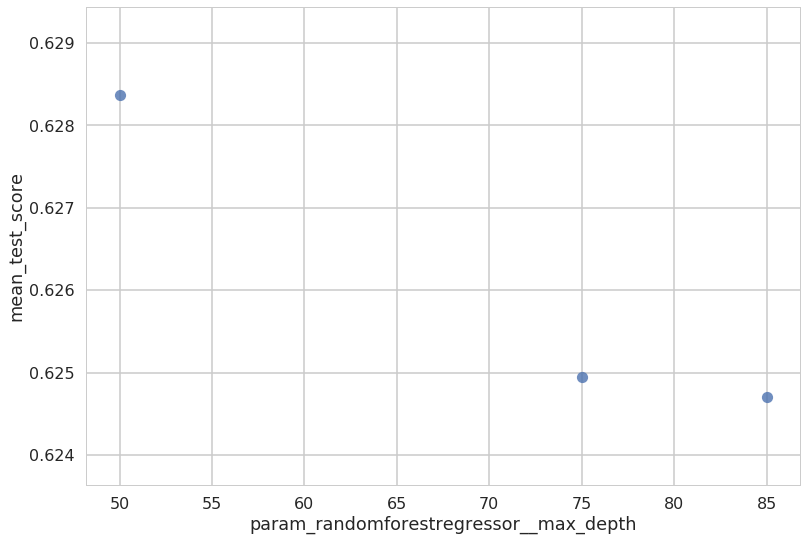

In [42]:
sns.regplot(
    x='param_randomforestregressor__max_depth',
    y='mean_test_score',
    data=results.T[['param_randomforestregressor__max_depth', 'mean_test_score']], 
    fit_reg=False
);

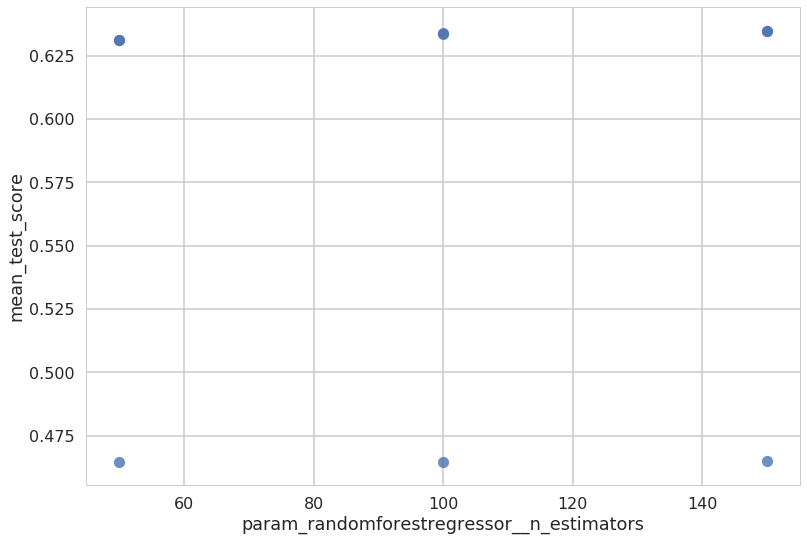

In [25]:
sns.regplot(
    x='param_randomforestregressor__n_estimators',
    y='mean_test_score',
    data=results.T[['param_randomforestregressor__n_estimators', 'mean_test_score']], 
    fit_reg=False
);